## Part 1: Introduction to Bayesian Thinking

In [2]:
import pandas as pd
df = pd.read_csv("spam_emails.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
 2   day     5728 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 134.4+ KB


**Task 1.1:** Using the Email Spam Dataset, create a function `prob_spam_given_keyword()` that applies Bayes’ theorem to compute the posterior probability of an email being spam, given a certain keyword. The function takes 2 inputs: (i) the path to the dataset (`file_path`), (ii) the word to estimate the spam probability for (`keyword`). If the keyword is not in any e-mail in the data, your function should return 0. 

In [17]:
def prob_spam_given_keyword(file_path, keyword):
    df['spam'] = df['spam'].apply(lambda x: 1 if x == 1 else 0)
    # Ensure label is binary (0 for non-spam, 1 for spam)
    contains_kw = df[df['text'].str.contains(keyword)]
    
    if contains_kw.empty:
        return 0
    return contains_kw['spam'].mean()
    
    # your code here
    raise NotImplementedError
prob_spam_given_keyword('spam_emails.csv', 'hello123')

0

In [ ]:
## TEST 1 CELL

**Task 1.2**: Create an updated Python function `prob_spam_given_keyword_Laplacian()` that uses Laplacian smoothing in order to deal with keywords that are not in the data. This function will have 4 arguments. The same 2 as above and 2 additional: (i) the Laplacian smoothing α for the conditional probabilities (`alpha_conditional`), and, (ii) the Laplacian smoothing α for the marginal probabilities (`alpha_marginal`). Remember that a good practice is to use a different α for smoothing the conditional and the marginal probabilities. Use a ratio of 0.01 for `alpha_conditional`/`alpha_marginal`. 

In [30]:
def prob_spam_given_keyword_Laplacian(file_path, keyword, alpha_conditional=0.01, alpha_marginal=1):
    df['spam'] = df['spam'].apply(lambda x: 1 if x == 1 else 0)
    # Ensure label is binary (0 for non-spam, 1 for spam)
    
    N = len(df)
    n_spam = df['spam'].sum()
    
    contains_kw = df[df['text'].str.contains(keyword)]
    n_K = len(contains_kw)
    n_K_spam = len(contains_kw[contains_kw['spam'] == 1])
    
    p_spam = (n_spam + alpha_marginal) / (N + 2 * alpha_marginal)
    
    p_K = (n_K + alpha_marginal) / (N + 2 * alpha_marginal)
    
    p_K_given_spam = (n_K_spam + alpha_conditional) / (n_spam + 2 * alpha_conditional)
    
    posterior = (p_K_given_spam * p_spam) / p_K
    
    return posterior
    
    # your code here
    raise NotImplementedError
prob_spam_given_keyword_Laplacian('spam_emails.csv', 'hello31232', 0.01,1.0)

0.010007163637958508

In [ ]:
## TEST 2 CELL

## Part 2: Bayes Theorem and Conjugate Priors

Using the Email Spam Dataset you will be tasked to identify the posterior distribution for the number of spam e-mails per day. The column `day` in the data represents the day that the email was received. There are 40 days overall in the data. You can use a **Gamma-Poisson** model for the number of spam emails received per day, and you can assume your prior distribution being a Gamma with an average of 50 (spam e-mails per day). First define and plot the prior.

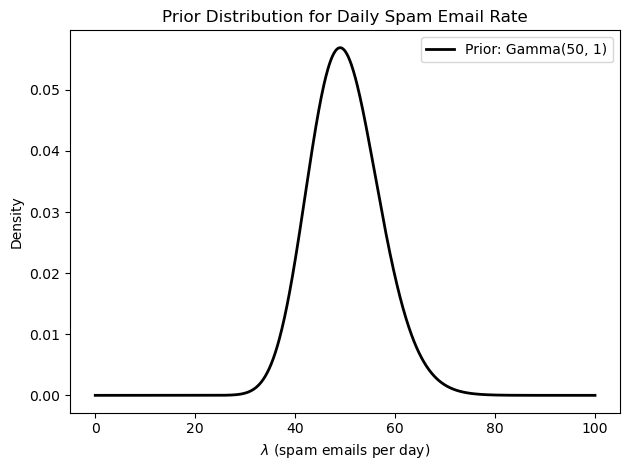

In [24]:
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt
from math import factorial
import scipy.integrate as integrate

fig, ax = plt.subplots(1, 1)

## create 1000 points on the line [0,100] to use for plotting the prior
x = np.linspace(0, 100, 1000)
    # insert code to:
    # (i) define the prior
    # (ii) plot the prior distribution over x
    # your code here
alpha_prior = 50
beta_prior = 1

prior_pdf = gamma.pdf(x, a=alpha_prior, scale=1/beta_prior)

ax.plot(x, 
        prior_pdf, 
        label=f'Prior: Gamma({alpha_prior}, {beta_prior})', 
        color='black', 
        lw=2)
ax.set_xlabel(r'$\lambda$ (spam emails per day)')
ax.set_ylabel('Density')
ax.set_title('Prior Distribution for Daily Spam Email Rate')
ax.legend()
plt.tight_layout()
plt.show()

You can then use every day as your observation for estimating the posteriors. You will calculate a total of 40 posteriors (as there are 40 days in the dataset). For `posterior_1` you will use as your prior the Gamma distribution with an average of 50 as mentioned above, while for `posterior_n` (n>1) your prior will be the` posterior_(n-1)`. 

**Task 2.1**: You will write two functions. The first one `update_posterior()` will get two arguments: (a) the prior function (`prior_func`), and, (b) the current observation (`observation`) that will be used to update the posterior. 

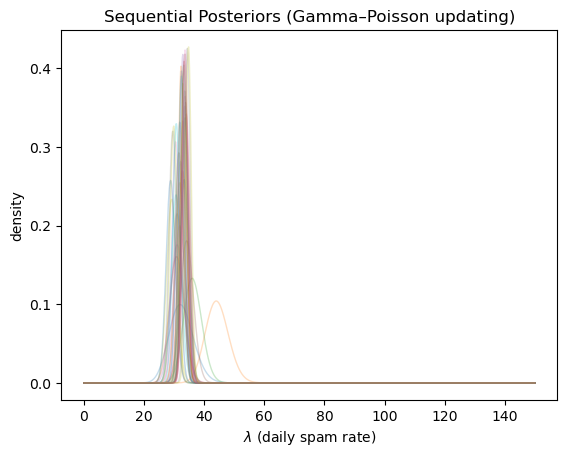

In [48]:
# update belief based on observations
# observations are the number of spam e-mails we received every day

obs = [sum(df[df['day'] == d]['spam']) for d in range(1, 40)]


def update_posterior(prior_func, observation):
    # your code here
    # defining the poisson likelihood
    likelihood = lambda x: (x**observation)* np.exp(-x)
    
    # mult prior by likelihood to get the unnormalized posterior
    unnorm_post = lambda x: prior_func(x) * likelihood(x)
    
    # calc the total prob for normalization
    tp = integrate.quad(unnorm_post, 0 , np.inf)[0]
    
    # defining the normalized posterior
    posterior = lambda x: unnorm_post(x)/tp
        
    return posterior
    raise NotImplementedError
    # implement update_posterior(prior_func, observation) function

# plot the posteriors
x = np.linspace(0, 150, 1000)
fig, ax = plt.subplots(1, 1)

a0, b0 = 50.0, 1.0 # mean =50
prior = lambda x: (x** (a0-1)) * np.exp(-b0 * x)

# sequentially update posteriors day-by-day
posteriors = []
current_prior = prior
for y in obs:  # obs should be the 40 daily spam counts
    post = update_posterior(current_prior, y)
    posteriors.append(post)
    current_prior = post

# plot all 40 posteriors (light) and label a few milestones
for i, post in enumerate(posteriors, start=1):
    ax.plot(x, [post(v) for v in x], alpha=0.25, linewidth=1)

ax.set_xlabel(r"$\lambda$ (daily spam rate)")
ax.set_ylabel("density")
ax.set_title("Sequential Posteriors (Gamma–Poisson updating)")
plt.show()
    # your code here
  
   # sequentially update posteriors and plot the new "curve"

**Task 2.2**: The second function `integrate_posterior()`, will call the function `update_posterior()`, will take as input a prior function (`prior`) and a list with the observations (`obs`) to sequentially update the posterior. This sequential update will make use of the `update_posterior()` function that performs one step of the update. Once the final posterior is calculated, then you can use this posterior to calculate and return the probability of the number of spam e-mails per day being between 2 values that are also given as parameters in the function (`a`,`b`). 

In [50]:
def integrate_posterior(a, b, prior, obs):
    # implment the function integrate_posterior(a,b, prior, obs)
    # your code here
    current = prior
    
    for ob in obs:
        current = update_posterior(current, ob)
    
    return integrate.quad(current, a, b)[0]

    raise NotImplementedError

In [ ]:
## TEST 3 CELL

## Part 3: Bayesian Estimation and Credible Intervals

**Task 3.1**: Using the final posterior distributions from Part 2, write a function `credible_interval_posterior()` that calculates the α% credible interval. This functions will take three arguments: (a) the posterior function (`posterior`), (b) the lower bound of the CI (`lower`), and, (c) the upper bound of the CI (`upper`). 

*Hint: for simplicity calculate the equal tails interval.*

In [55]:
def credible_interval_posterior(posterior, lower, upper):
    # implement credible_interval_posterior(posterior,lower, upper)
    # your code here
    x_vals = np.linspace(0, 200, 10000)
    dx = x_vals[1] - x_vals[0]
    
    pdf_vals = np.array([posterior(xi) for xi in x_vals])
    
    cdf_vals = np.cumsum(pdf_vals) * dx
    
    # Locate equal-tailed bounds
    lower_bound = x_vals[np.searchsorted(cdf_vals, lower)]
    upper_bound = x_vals[np.searchsorted(cdf_vals, upper)]

    return lower_bound, upper_bound
    
    raise NotImplementedError
    
final_posterior = posteriors[-1]
credible_interval_posterior(final_posterior, 0.025, 0.975)

(33.00330033003301, 36.643664366436646)

In [ ]:
## TEST 4 CELL

**Optional/Extra credit** 

**Task 3.2**: Compare the Bayesian credible intervals with frequentist confidence intervals for the same data. Explain briefly any differences observed in part 2 of the assignment (**Q3**). 

In [61]:
from scipy.stats import chi2

# Observations: number of spam e-mails every day
obs = [sum(df[df['day'] == d]['spam']) for d in range(1, 40)]

# ---------- Frequentist estimates for the Poisson mean per day ----------
sample_mean = np.mean(obs)
n = len(obs)

# Normal-approx 95% CI for the Poisson mean (per day)
z = 1.96
# Normal approximation confidence interval for Poisson mean
standard_error = np.sqrt(sample_mean / n)
z = 1.96  # 95% confidence
ci_lower = sample_mean - z * standard_error
ci_upper = sample_mean + z * standard_error
print(f'Frequentist sample mean: {sample_mean:.2f}')
print(f'95% CI (normal approx): [{ci_lower:.2f}, {ci_upper:.2f}]')
# Exact Poisson confidence interval for the mean using chi-squared method
alpha = 0.05
sum_obs = np.sum(obs)
lower_total = 0.5 * chi2.ppf(alpha/2, 2 * sum_obs)
upper_total = 0.5 * chi2.ppf(1 - alpha/2, 2 * (sum_obs + 1))
ci_lower_chi = lower_total / n
ci_upper_chi = upper_total / n
print(f"95% CI (chi-squared):    [{ci_lower_chi:.2f}, {ci_upper_chi:.2f}]")

# --- Bayesian credible interval for the posterior mean ---

# Use the Gamma(3,1) prior and update with all observations
prior_rv = gamma(a=3, scale=1/1)
prior = lambda lam: prior_rv.pdf(lam)
posterior = prior
for ob in obs:
    posterior = update_posterior(posterior, ob)

# 95% equal-tailed credible interval via your credible_interval_posterior()
bayes_lower, bayes_upper = credible_interval_posterior(posterior, 0.025, 0.975)
print(f"Bayesian 95% credible interval: [{bayes_lower:.2f}, {bayes_upper:.2f}]")
    
# your code here
# (optional for the frequentist estimate of the sample mean and CI)



Frequentist sample mean: 34.41
95% CI (normal approx): [32.57, 36.25]
95% CI (chi-squared):    [32.59, 36.30]
Bayesian 95% credible interval: [31.84, 35.44]


The difference is what the intervals mean. A frequentist 95% CI is about the procedure and if we repeated the study over and over about 95% of those intervals would capture the true rate. It isn;t saying theres a 95% chance the true value is in this specific intervals. While the Bayesian 95% CI is the opposite given our data and our prior. Theres a 95% probability the truue rate is inisde that interval. It's a direct probability statement about the parameter.

The prior mean is 50 so if we dont have many observations the bayesian interval might lean in the direction towards the pull and may be tighter as the prior adds some information. WIth much more data the pull fades and both approaches usually land in the same place. 

## Part 4: Daily Spam E-mails Using MCMC 

Use the *Metropolis-Hastings algorithm* to estimate the posterior distribution for the number of spam e-mails received per day. Assume that the number of spam e-mails per day follows a Poisson distribution with an unknown rate λ. You can use as your prior distribution for λ the conjugate of Poisson, i.e., Gamma. You can assume the prior distribution Gamma to have a mean equal to the average daily e-mails (either spam or not) in the dataset. 

**Task 4.1**: Estimate the posterior distribution for λ using the following two proposal distributions:

q(λ’|λ) = N(λ, 2) - normal proposal

q(λ’|λ) = U(λ-δ, λ+δ) - uniform proposal
 
*Hint:* Use σ=5 for the normal proposal and δ = 3 for the uniform proposal. Initialize the chain with the method of moments (i.e., the mean rate from the data). 
	
Calculate the acceptance rate of your sampling and plot (a) the trace, and, (b) the autocorrelation of the trace to visually inspect. 

Finally briefly comment for stationarity and mixing at part 2 of the assignment; you can also share the trace plots and autocorrelation plots (**Q4**). 


Initial Lambda: 36.0
Acceptance Rate: 0.982


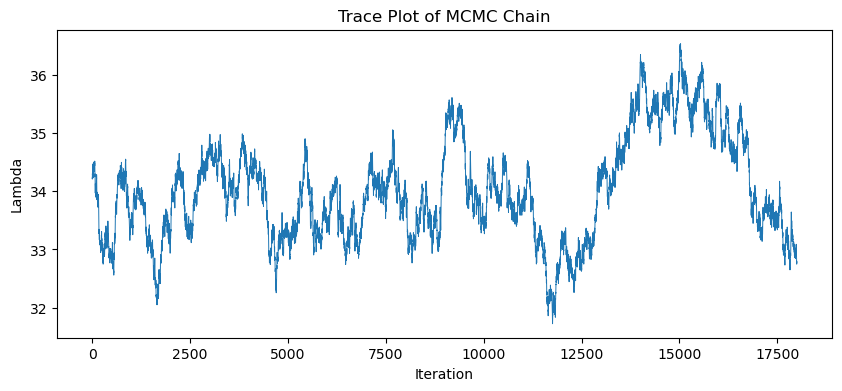

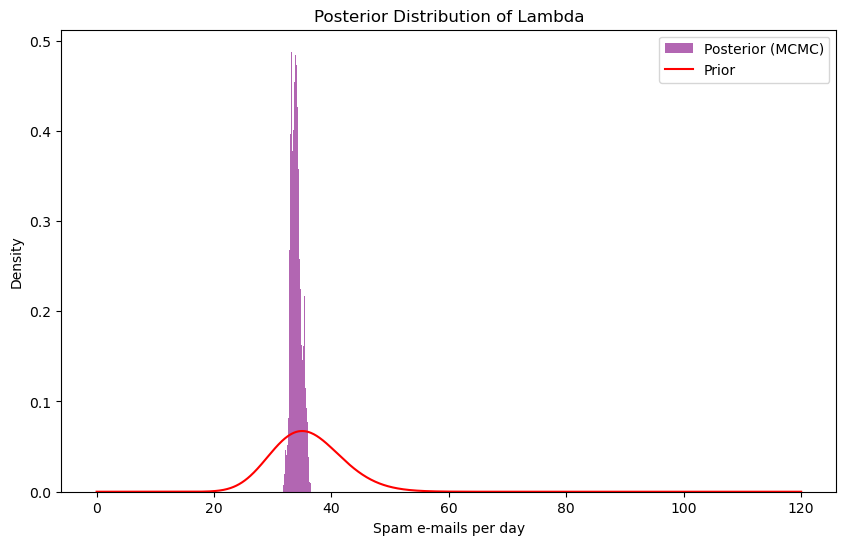

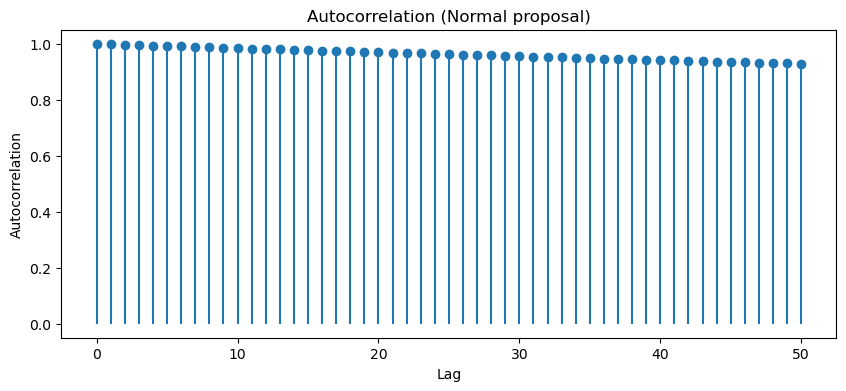

Posterior Mean: 34.01
95% Credible Interval: [32.50, 35.86]


In [4]:
import numpy as np
from scipy.stats import gamma, poisson
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf

# the observations of the number of daily spam e-mails
data = [sum(df[df['day'] == d]['spam']) for d in range(1, 40)]

# Initialize lambda as the sample mean of daily e-mails (not only spam)
initial_lambda = np.floor(0.25 * np.mean([len(df[df['day'] == d]['spam']) for d in range(1, 40)]))
print("Initial Lambda:", initial_lambda)

# Gamma Prior
rv = gamma(initial_lambda)
prior = lambda x: rv.pdf(x)

# your code here
def likelihood( lam, data):
    if np.any(lam <=0):
        return 0.0
    return float(np.exp(np.sum(poisson.logpmf(data,lam))))
# implement: Likelihood function for Poisson model; likelihood(lam, data)
# implement: Posterior (up to a constant); posterior(lam, data)
def posterior(lam, data):
    if lam <= 0:
        return 0.0
    return prior(lam) * likelihood(lam, data)

# implement: Metropolis-Hastings Algorithm; metropolis_hastings_normal(data, initial_lambda, sigma, iterations=10000, burn_in=1000). This function should return the chain samples and the number of samples accepted
def metropolis_hastings_normal(data, initial_lambda, sigma, iterations=10000, burn_in=1000):
    # Initialize storage for samples
    samples = []
    # Start at the initial lambda value
    current = float(initial_lambda)
    # Compute the current posterior
    current_post = posterior(current, data)
    # Track the number of accepted proposals
    accepted = 0

    # Iterate for the specified number of iterations
    for i in range(iterations):
        proposal = np.random.normal(current, sigma)
        if proposal <= 0:
            # invalid λ => reject
            proposal_post = 0.0
            alpha = 0.0
        else:
            proposal_post = posterior(proposal, data)
            # symmetric proposal to Hastings ratio simplifies to posterior ratio
            alpha = min(1.0, proposal_post / current_post) if current_post > 0 else 1.0

        if np.random.rand() < alpha:
            current = proposal
            current_post = proposal_post
            accepted += 1

        if i >= burn_in:
            samples.append(current)
    # Return the chain and number of accepted proposals
    return np.array(samples), accepted

# Parameters
sigma = .05  # Standard deviation for Normal proposal
iterations = 20000
burn_in = 2000
delta = .03

# Run Metropolis-Hastings
chain, accepted = metropolis_hastings_normal(data, initial_lambda, sigma, iterations, burn_in)


# your code here
# Print acceptance rate and calculate and display the acceptance rate of the sampler
acceptance_rate = accepted / iterations
print(f"Acceptance Rate: {acceptance_rate:.3f}")
# Print acceptance rate


# your code here
# Plot the MCMC chain
plt.figure(figsize=(10,4))
plt.plot(chain, lw=0.7)
plt.xlabel('Iteration')
plt.ylabel('Lambda')
plt.title('Trace Plot of MCMC Chain')
plt.show()

# Posterior distribution from MCMC samples
plt.figure(figsize=(10, 6))
plt.hist(chain, bins=30, density=True, color='purple', alpha=0.6, label='Posterior (MCMC)')
x = np.linspace(0, 120, 1000)
plt.plot(x, prior(x), label='Prior', color='red')
plt.xlabel("Spam e-mails per day")
plt.ylabel("Density")
plt.title("Posterior Distribution of Lambda")
plt.legend()
plt.show()

# your code here
# Plot the autocorrelation with maximum number of lags 50
lags = 50
acf_vals_norm = acf(chain, nlags=lags)
plt.figure(figsize=(10, 4))
plt.stem(range(lags+1), acf_vals_norm, basefmt=" ")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation (Normal proposal)')
plt.show()

# Posterior mean and 95% credible interval
post_mean = np.mean(chain)
cred_interval = np.percentile(chain, [2.5, 97.5])
print(f"Posterior Mean: {post_mean:.2f}")
print(f"95% Credible Interval: [{cred_interval[0]:.2f}, {cred_interval[1]:.2f}]")

Acceptance Rate: 0.992


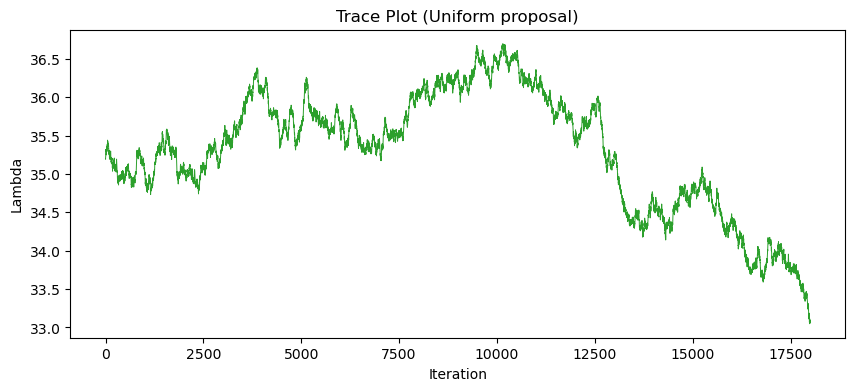

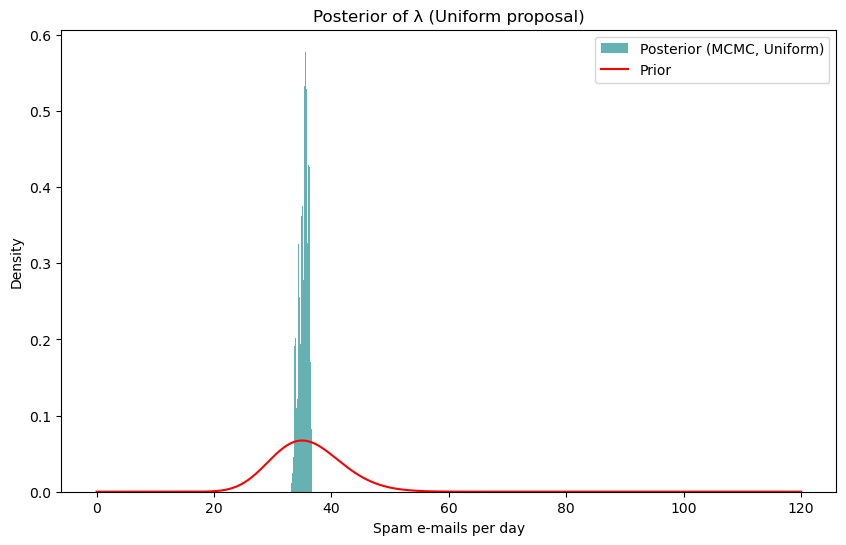

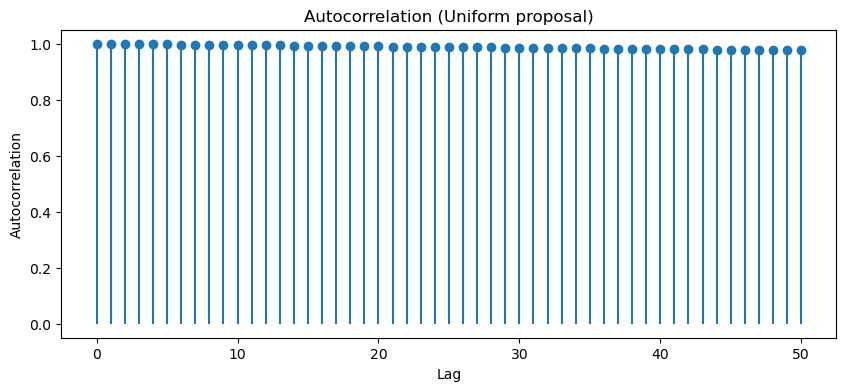

In [6]:
# Metropolis–Hastings with Uniform(λ-δ, λ+δ) proposal
def metropolis_hastings_uniform(data, initial_lambda, delta, iterations=10000, burn_in=1000):
    delta = .03  # fixed per instructions

    samples = []
    current = float(initial_lambda)
    current_post = posterior(current, data)
    accepted = 0

    for i in range(iterations):
        proposal = current + np.random.uniform(-delta, delta)

        if proposal <= 0:
            proposal_post = 0.0
            alpha = 0.0
        else:
            proposal_post = posterior(proposal, data)
            # symmetric window ⇒ Metropolis acceptance
            alpha = min(1.0, proposal_post / current_post) if current_post > 0 else 1.0

        if np.random.rand() < alpha:
            current = proposal
            current_post = proposal_post
            accepted += 1

        if i >= burn_in:
            samples.append(current)

    return np.array(samples), accepted
# your code here
# Run Metropolis-Hastings
chain, accepted = metropolis_hastings_uniform(data, initial_lambda, delta, iterations, burn_in)

# your code here
# Print acceptance rate and calculate and display the acceptance rate of the sampler
acceptance_rate = accepted / iterations
print(f"Acceptance Rate: {acceptance_rate:.3f}")
# Print acceptance rate

# your code here
# Plot the MCMC chain
plt.figure(figsize=(10, 4))
plt.plot(chain, lw=0.7, color='tab:green')
plt.xlabel('Iteration')
plt.ylabel('Lambda')
plt.title('Trace Plot (Uniform proposal)')
plt.show()

# Posterior distribution from MCMC samples
plt.figure(figsize=(10, 6))
plt.hist(chain, bins=30, density=True, color='teal', alpha=0.6, label='Posterior (MCMC, Uniform)')
x = np.linspace(0, 120, 1000)
plt.plot(x, prior(x), label='Prior', color='red')
plt.xlabel("Spam e-mails per day")
plt.ylabel("Density")
plt.title("Posterior of λ (Uniform proposal)")
plt.legend()
plt.show()

# your code here
# Plot the autocorrelation with maximum number of lags 50
lags = 50
acf_vals_norm = acf(chain, nlags=lags)
plt.figure(figsize=(10, 4))
plt.stem(range(lags+1), acf_vals_norm, basefmt=" ")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation (Uniform proposal)')
plt.show()
# Implement the above cell again by changing the proposal function to a uniform distribution as described in Task 4.1